# Magnetic levitation system

 *************** Created by Pablo Borja *******************
 
 ***** Contact: pablo.borjarosales@plymouth.ac.uk ***** 
 
 ***** SECaM, Univerity of Plymouth, Plymouth, UK ***** 
 

Importing packages...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

from scipy.integrate import solve_ivp

## Parameters for simulation

Parameters of the plant

In [2]:
mb = 0.1; 
rho = 0.05; 
k = 0.01; 
gr = 9.8; 
r = 8; 

We choose the desired equilibrium. Remember that the set of assignable equilibria is given by

$$\mathcal{E}=\left\lbrace x\in\mathbb{R}^{3}\mid p=0, \varphi=\displaystyle\sqrt{2km_{\tt b}g_{\tt r}} 
\right\rbrace.$$


In [3]:
qd = -0.02; # Desired position. Modify if necessary.
phid = np.sqrt(2*mb*gr*k);


Initial conditions

Modify to simulate different initial conditions


In [4]:
y0 = [0, 0, 0.1];

Initial and final time

In [6]:
t0 = 0;

tf = 20; # Modify if you want to simulate a longer or shorter period

t = np.linspace(t0, tf, 1000)

Control gains 

In [7]:
Kz = 0.08; #Gain. Modify if necessary
Kdi = 3; #Damping injection gain. The system has natural damping (in the electrical part), but you can add more (if wanted)

## System (ODE)

Below, we briefly explain how to obtain the closed-loop dynamics. Please see the PDF file "Examples" to understand this part.

================================

For implementation purposes, it's simpler to consider the three dynamics independently because only $\dot{\varphi}$ is affected by the control input. Thus, we can directly implement

$$\begin{array}{rcl}
\dot{q} &=& \frac{p}{m_{\tt b}}; \\
\dot{p} &=& -m_{\tt b}g_{\tt r} + \frac{\varphi^{2}}{2k}
\end{array}
$$

Note that

$$F_{\tt uu}=\begin{bmatrix}
0 & 1  \\ -1 & 0 \\
    \end{bmatrix}, \qquad F_{\tt au}=\begin{bmatrix}
0 & 0 
    \end{bmatrix}, \qquad F_{\tt aa} = -r.$$

The Hamiltonian's gradient is

$$\frac{\partial H(x)}{\partial x} = \begin{bmatrix} m_{\tt b}g_{\tt r} - \frac{\varphi^{2}}{2k} \\ \frac{p}{m_{\tt b}} \\ \frac{1}{k}\varphi(\rho - q) \end{bmatrix}.$$

Additionally,

$$\sigma = 1, \quad \Upsilon = \begin{bmatrix} -1 \\ 0 \end{bmatrix}, \quad \beta_{\tt u}(x_{\tt u}) = \begin{bmatrix}
     m_{\tt b}g_{\tt r} \\
     \frac{p}{m_{\tt b}}   \end{bmatrix}, \quad \beta_{\tt 
a}(x_{\tt a}) = \frac{1}{2k}\varphi^{2}, \quad z(x) = q+\varphi.$$

Hence, for the suggested $\Psi(z(x))$, we obtain

$$\frac{\partial \Psi(z(x))}{\partial x} = \begin{bmatrix} K_{\tt z}(q+\varphi-q_{\tt d}-\varphi_{\tt d})-m_{\tt b}g_{\tt r} \\ 0 \\ K_{\tt z}(q+\varphi-q_{\tt d}-\varphi_{\tt d})-m_{\tt b}g_{\tt r}\end{bmatrix}.$$

Therefore,

$$\frac{\partial H_{\tt d}(x)}{\partial x} = \begin{bmatrix} K_{\tt z}(q+\varphi-q_{\tt d}-\varphi_{\tt d})-m_{\tt b}g_{\tt r} \\ 0 \\ K_{\tt z}(q+\varphi-q_{\tt d}-\varphi_{\tt d})-m_{\tt b}g_{\tt r}\end{bmatrix} + \begin{bmatrix}
     m_{\tt b}g_{\tt r} \\
     \frac{p}{m_{\tt b}} \\  \frac{1}{2k}\varphi^{2} \end{bmatrix}$$

Hence, the control law reduces to

$$\begin{array}{rcl}
u &=& -\sigma\Upsilon^{\top}F_{\tt uu}^{\top}(x)\frac{\partial H_{\tt d}(x)}{\partial x_{\tt u}}+F_{\tt aa}(x)\left(\frac{\partial H_{\tt d}(x)}{\partial x_{\tt
a}}-\frac{\partial H(x)}{\partial x_{\tt a}}  \right)-K_{\tt di}\frac{\partial H_{\tt d}(x)}{\partial x_{\tt a}}- F_{\tt au}(x)\frac{\partial H(x)}{\partial x_{\tt u}}\\
&=& -\frac{p}{m_{\tt b}}-(r+K_{\tt di})\left(K_{\tt z}(q+\varphi-q_{\tt d}-\varphi_{\tt d})-m_{\tt b}g_{\tt r}+ \frac{1}{2k}\varphi^{2}\right)+\frac{r}{k}\varphi(\rho - q).
\end{array}
$$

To obtain the closed-loop dynamics, we substitute the control law $u$ obtained above into

$$\dot{\varphi} = -\frac{r}{k}\varphi(\rho - q)+u.$$

In [8]:
def maglev_ode(t, y, mb, rho, k, gr, r, qd, phid, Kz, Kdi):
    q, p, phi = y
    
    # Controller

    u = -p/mb-(r+Kdi)*(Kz*(q+phi-qd-phid)-mb*gr+(phi**2)/(2*k))+r*phi*(rho-q)/k

    return [p/mb, -mb*gr+(phi**2)/(2*k),-r*phi*(rho-q)/k+u]

## ODE solution

In [9]:
sol_ivp = solve_ivp(maglev_ode,[t0,tf],y0,args=(mb, rho, k, gr, r, qd, phid, Kz, Kdi), dense_output=True, rtol = 1e-6, atol = 1e-10)

p = sol_ivp.sol(t)

## Plots

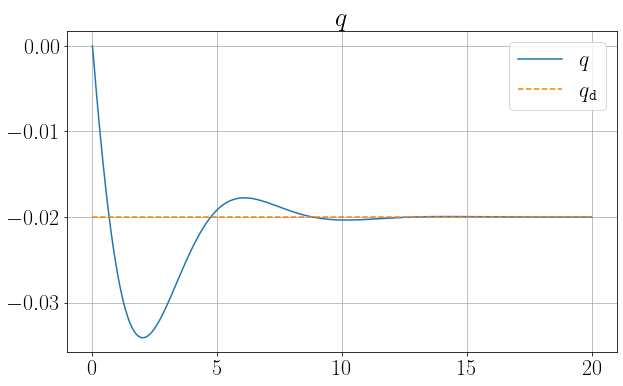

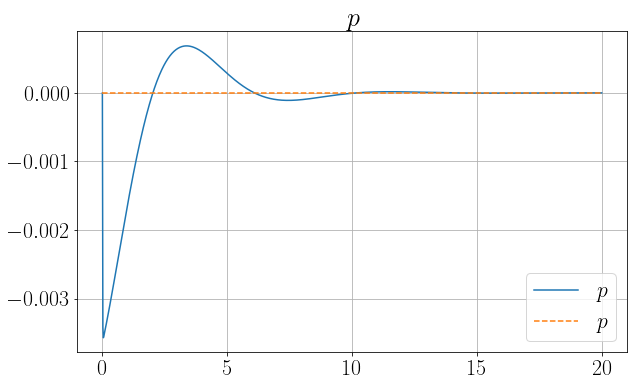

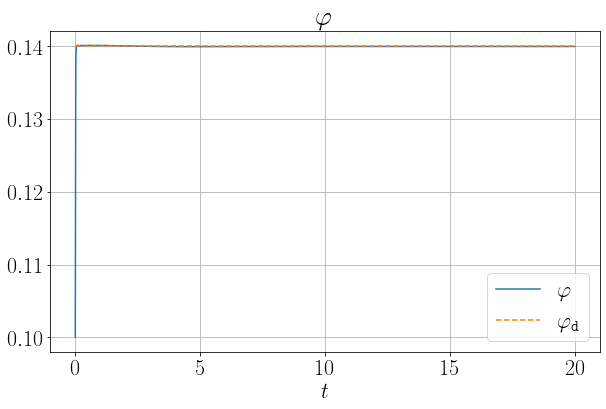

In [10]:
plt.rcParams['text.usetex'] = True
cm = 1/2.54

plt.rcParams.update({'font.size': 22})

plt.figure(figsize=(25*cm, 15*cm))
plt.plot(t, p[0].T, label = '$q$')
plt.plot([t0,tf], [qd,qd],'--',label = '$q_{\\tt d}$')
plt.title('$q$')
plt.grid()
plt.legend(loc='best')


plt.figure(figsize=(25*cm, 15*cm))
plt.plot(t, p[1].T,label = '$p$')
plt.plot([t0,tf], [0,0],'--',label = '$p$')
plt.title('$p$')
plt.legend(loc='best')
plt.grid()

plt.figure(figsize=(25*cm, 15*cm))
plt.plot(t, p[2].T,label = '$\\varphi$')
plt.plot([t0,tf], [phid,phid],'--',label = '$\\varphi_{\\tt d}$')
plt.title('$\\varphi$')
plt.xlabel('$t$')
plt.legend(loc='best')
plt.grid()
plt.show()